In [9]:
import librosa
import numpy as np
import pandas as pd
import h5py
import scipy.io.wavfile as wav
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential, Model, Input
from keras.layers import Dense, LSTM

from sklearn.model_selection import StratifiedShuffleSplit

import sys
sys.path.append('..')

%matplotlib inline

from laughter_classification.sspnet_data_sampler import SSPNetDataSampler

In [2]:
RATE = 16000 # samples in sec
DUR = 11 # file duration in seconds
LEN = RATE * DUR # samples in file (176000)
FRAME_SEC = 0.5 # seconds in frame
FRAME_SIZE = int(RATE * FRAME_SEC) # samples if frame (8000)
FRAME_STEP = int(FRAME_SIZE / 5) # samples between successive frames (1600)
NUM_CLASSES = 2 # laught or not

* Added `LibrosaExtractor` in `laughter_prediction.feature_extractors` to extract MFCC and FBANK features using librosa, using it in `SSPNetDataSampler`.


* Rewrote `SSPNetDataSampler` in `laughter_classification.sspnet_data_sampler` which creates dataset from vocalizationcorpus and returns DataFrame with overlapping frames described by features, label of class and filename.

In [3]:
# smplr = SSPNetDataSampler('../../data/vocalizationcorpus/')
# data = smplr.create_sampled_df(FRAME_SEC)
# data.to_csv('../../data/samples.csv', index=False)

data = pd.read_csv('../../data/samples.csv')

In [4]:
data.shape

(287175, 150)

In [32]:
frames_num = 105 # number of frames for each .wav file
vector_len = 148 # number of features describing each frame
mfcc_len = 20
fbank_len = 128

In [6]:
data.head()

,V0,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V140,V141,V142,V143,V144,V145,V146,V147,IS_LAUGHTER,SNAME
0,903.469993,22.110552,13.151943,46.213083,-17.533179,23.288871,-17.945700,4.478985,-16.021022,-8.827005,...,8.985123e+07,4.989764e+07,4.625960e+07,3.625273e+07,5.107908e+07,7.357580e+07,6.407850e+07,7.800024e+06,False,S1584
1,984.319736,21.231838,2.953489,44.678074,-19.402026,14.163532,-21.600310,0.101438,-18.760751,-7.042315,...,2.104042e+08,2.243163e+08,3.022200e+08,2.158124e+08,1.993383e+08,1.572147e+08,1.265192e+08,2.348908e+07,False,S1584
2,1022.190698,33.532349,-3.279695,38.394860,-25.989993,9.349846,-21.051692,-6.710757,-19.321560,-5.070256,...,2.286517e+08,2.385465e+08,3.099776e+08,2.240567e+08,2.065902e+08,1.629597e+08,1.324797e+08,2.509720e+07,False,S1584
3,1061.268787,30.639947,-4.961195,29.276434,-25.571131,8.788084,-21.397945,-6.496737,-16.397063,-1.047615,...,6.105167e+08,4.207161e+08,3.784505e+08,3.184893e+08,2.554543e+08,1.928747e+08,1.593636e+08,3.782155e+07,False,S1584
4,1074.259395,33.744219,-11.850305,20.757621,-25.812979,4.828652,-22.944275,-5.730192,-17.161470,1.973448,...,9.164058e+08,7.139229e+08,4.837591e+08,4.990330e+08,3.617077e+08,1.806479e+08,1.369564e+08,4.479941e+07,False,S1584


Let's see distribution of laugh frames number for files.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124a7b9d0>]],
      dtype=object)

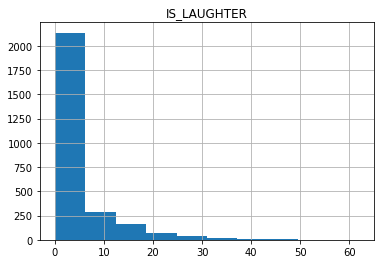

In [7]:
pivoted = data.pivot_table(index='SNAME', values='IS_LAUGHTER', aggfunc=np.sum)
pivoted.hist()

In [10]:
pivoted.head(2)

,IS_LAUGHTER
SNAME,
S0001,0.0
S0002,12.0


Dividing dataset into `train` and `test` subsets saving the distribution.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x124e8a4d0>]],
      dtype=object)

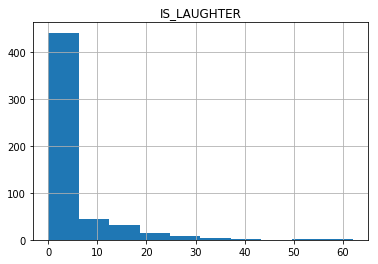

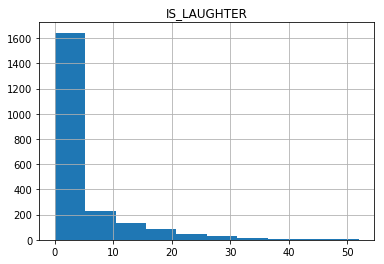

In [11]:
X = pivoted['IS_LAUGHTER'].index
y = pivoted['IS_LAUGHTER'].values // 21

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=0)
for train_index, test_index in sss.split(X, y):
    X_train, X_test = X[train_index], X[test_index]
    
test = data[data['SNAME'].isin(X_test)]
train = data[data['SNAME'].isin(X_train)]

test.pivot_table(index='SNAME', values='IS_LAUGHTER', aggfunc=np.sum).hist()
train.pivot_table(index='SNAME', values='IS_LAUGHTER', aggfunc=np.sum).hist()

In [12]:
train = np.array(train.drop(columns='SNAME')).astype(float)
test = np.array(test.drop(columns='SNAME')).astype(float)

In [13]:
X_train, y_train = train[:, :-1].reshape(len(train) // frames_num, frames_num, vector_len), train[:, -1]
X_test, y_test = test[:, :-1].reshape(len(test) // frames_num, frames_num, vector_len), test[:, -1]

X shape:
* `number of .wav files`
* `number of frames in each file`
* `number of features describing each frame`

In [14]:
X_test.shape

(547, 105, 148)

In [15]:
y_train = keras.utils.to_categorical(y_train, NUM_CLASSES).reshape(len(train) // frames_num, frames_num, NUM_CLASSES)
y_test = keras.utils.to_categorical(y_test, NUM_CLASSES).reshape(len(test) // frames_num, frames_num, NUM_CLASSES)

y shape:
* `number of .wav files`
* `number of frames in each file`
* `one-hot encoding for two classes`

In [16]:
y_test.shape

(547, 105, 2)

In [17]:
del data

In [33]:
mfcc_input = Input(shape=(frames_num, mfcc_len))
fbank_input = Input(shape=(frames_num, fbank_len))

mfcc_lstm = LSTM(100, return_sequences=True)(mfcc_input)
fbank_lstm = LSTM(100, return_sequences=True)(fbank_input)

mfcc_output = Dense(NUM_CLASSES, activation='softmax')(mfcc_lstm)

x = keras.layers.concatenate([mfcc_lstm, fbank_lstm])
main_output = Dense(NUM_CLASSES, activation='softmax')(x)

model = Model(inputs=[mfcc_input, fbank_input], outputs=[main_output, mfcc_output])

model.compile(optimizer='rmsprop', loss='categorical_crossentropy',metrics=['accuracy'])

In [34]:
model.fit([X_train[:,:,:mfcc_len], X_train[:,:,mfcc_len:]], [y_train, y_train],
          epochs=10, batch_size=10)

Epoch 1/10
2188/2188 [==============================] - 38s 18ms/step - loss: 0.3226 - dense_3_loss: 0.1614 - dense_2_loss: 0.1612 - dense_3_acc: 0.9617 - dense_2_acc: 0.9632
Epoch 2/10
2188/2188 [==============================] - 36s 16ms/step - loss: 0.2756 - dense_3_loss: 0.1327 - dense_2_loss: 0.1430 - dense_3_acc: 0.9634 - dense_2_acc: 0.9634
Epoch 3/10
2188/2188 [==============================] - 35s 16ms/step - loss: 0.2614 - dense_3_loss: 0.1255 - dense_2_loss: 0.1359 - dense_3_acc: 0.9635 - dense_2_acc: 0.9634
Epoch 4/10
2188/2188 [==============================] - 42s 19ms/step - loss: 0.2542 - dense_3_loss: 0.1222 - dense_2_loss: 0.1319 - dense_3_acc: 0.9636 - dense_2_acc: 0.9634
Epoch 5/10
2188/2188 [==============================] - 58s 26ms/step - loss: 0.2504 - dense_3_loss: 0.1205 - dense_2_loss: 0.1299 - dense_3_acc: 0.9636 - dense_2_acc: 0.9634
Epoch 6/10
2188/2188 [==============================] - 36s 16ms/step - loss: 0.2480 - dense_3_loss: 0.1193 - dense_2_loss: 0

In [42]:
y_pred, _ = model.predict([X_test[:,:,:mfcc_len], X_test[:,:,mfcc_len:]])

In [43]:
y_pred.shape

(547, 105, 2)

In [44]:
y_test.shape

(547, 105, 2)

In [48]:
(y_test[:, :, 1] == (y_pred[:, :, 1] > 0.3)).sum() / (547. * 105) # accuracy

0.9664316183511796

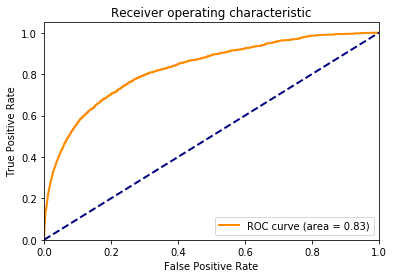

In [49]:
from sklearn.metrics import roc_curve, auc

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(y_test.reshape(-1, 2)[:, i], y_pred.reshape(-1, 2)[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])
    
# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

class_id = 1

plt.figure()
lw = 2
plt.plot(fpr[class_id], tpr[class_id], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[class_id])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic')
plt.legend(loc="lower right")
plt.show()

Let's display a couple samples with true intervals and predicted probability.

In [50]:
ind_to_display = np.argsort(y_test[:, :, 1].sum(axis=1))[-3:]

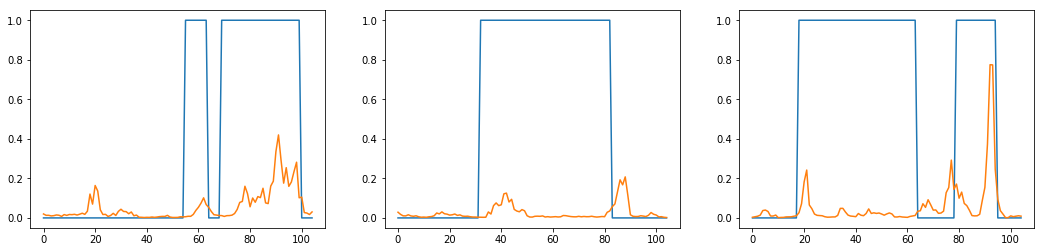

In [51]:
fig = plt.figure(figsize=(18, 4))

for i, ind in enumerate(ind_to_display):
    ax = fig.add_subplot(1, 3, i+1)
    ax.plot(np.arange(frames_num), y_test[ind][:, 1], label='true')
    ax.plot(np.arange(frames_num), y_pred[ind][:, 1], label='pred')

Saving model. It will be used in `laughter_prediction.predictors` to detect laughter segments. To run `laughter_prediction.predictors` run the following command:


`python2 process_audio.py --wav_path=<wav_path>`


For example:
> `python2 process_audio.py --wav_path="../../data/vocalizationcorpus/data/S1582.wav"`

> \>`Target intervals`

> \>`[(0.7, 1.2), (1.2, 1.8), (3.6, 4.1)]`


In [52]:
model.save('../rnn-model.h5')

Model description:

In [54]:
model.evaluate([X_train[:,:,:mfcc_len], X_train[:,:,mfcc_len:]], [y_train, y_train])

2188/2188 [==============================] - 6s 3ms/step


[0.25053580799965797,
 0.12039690866548793,
 0.1301388989527875,
 0.9637938505770738,
 0.9633759930321242]

In [56]:
model.evaluate([X_test[:,:,:mfcc_len], X_test[:,:,mfcc_len:]], [y_test, y_test])

547/547 [==============================] - 1s 2ms/step


[0.2532936695084602,
 0.12280353752238986,
 0.13049013372953347,
 0.9657177724611606,
 0.9654566016885873]

In [59]:
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 105, 20)      0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 105, 128)     0                                            
__________________________________________________________________________________________________
lstm_2 (LSTM)                   (None, 105, 100)     48400       input_1[0][0]                    
__________________________________________________________________________________________________
lstm_3 (LSTM)                   (None, 105, 100)     91600       input_2[0][0]                    
__________________________________________________________________________________________________
concatenat